# Проект: вариант 2
***
# Задание 1. A/B–тестирование
***
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?
- Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [1]:
# Подключение требуемых библиотек
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm.auto import tqdm

In [2]:
# Загружаем данные
url_base = 'https://getfile.dokpub.com/yandex/get/'
url_groups = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
df_groups = pd.read_csv(url_base + url_groups, sep=';')
url_active_studs = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
df_active_studs = pd.read_csv(url_base + url_active_studs, sep=';')
url_checks = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'
df_checks = pd.read_csv(url_base + url_checks, sep=';')

Посмотрим данные и их описательные параметры

In [3]:
df_groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# проверка формы таблицы
df_groups.shape

(74484, 2)

In [5]:
# проверка количества уникальных значений
df_groups.nunique()

id     74484
grp        2
dtype: int64

In [6]:
# распределение значений по группам
df_groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [7]:
# распределение значений в процентах по группам
(df_groups.grp.value_counts() * 100 / df_groups.shape[0]).round(2)

B    80.3
A    19.7
Name: grp, dtype: float64

In [8]:
# наличие NaN значений
df_groups.isna().sum()

id     0
grp    0
dtype: int64

Как видно, в датафрейме df_groups все значения id уникальны, нет NaN значений, распределение по группам (контрольная/тестовая), приблизительно 1 к 4

In [9]:
df_active_studs.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [10]:
# проверка формы таблицы
df_active_studs.shape

(8341, 1)

In [11]:
# проверка количества уникальных значений
df_active_studs.nunique()

student_id    8341
dtype: int64

In [12]:
# наличие NaN значений
df_active_studs.isna().sum()

student_id    0
dtype: int64

В датафрейме df_active_studs все значения id уникальны и нет NaN значений

In [13]:
df_checks.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [14]:
# проверка формы таблицы
df_checks.shape

(541, 2)

In [15]:
# описательные статистики числовых значений
df_checks.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


In [16]:
# проверка количества уникальных значений
df_checks.nunique()

student_id    541
rev            39
dtype: int64

In [17]:
# наличие NaN значений
df_checks.isna().sum()

student_id    0
rev           0
dtype: int64

В датафрейме df_checks все значения id уникальны и нет NaN значений

## Подготовка данных
***
Далее объединим таблицу с разделением на группы с таблицами чеков и активности юзеров

In [18]:
# но прежде приведем в соотвествие название айди студентов во всех датафреймах
df_list = [df_active_studs, df_checks]
for i in df_list:
    i.rename(columns={'student_id': 'id'}, inplace=True)

In [19]:
# объединение датафреймов активных пользователей и разделение на группы
df_active_groups = df_active_studs.merge(df_groups, how='left', on='id')
df_active_groups.head(5)

,id,grp
0,581585,A
1,5723133,NaN
2,3276743,B
3,4238589,A
4,4475369,B


In [20]:
df_active_groups.shape

(8341, 2)

В списке активных пользователей присутствуют те, которые не относятся ни к контрольной, ни к тестовой группе. Для корректного проведения теста и его интерпритации не будем их учитывать

In [21]:
df_active_groups.dropna(inplace=True)

In [22]:
# проверяем изменение в размере фрейма
df_active_groups.shape

(8328, 2)

In [23]:
# объединение датафреймов оплат пользователей и разделение на группы
df_checks_groups = df_checks.merge(df_groups, how='left', on='id')
df_checks_groups.head(5)

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B


In [24]:
df_checks_groups.shape

(541, 3)

In [25]:
# проверяем NaN значения
df_checks_groups.isna().sum()

id     0
rev    0
grp    1
dtype: int64

In [26]:
# и так же, оставляем только тех пользователей, что участвуют в эксперименте
df_checks_groups.dropna(inplace=True)

In [27]:
df_checks_groups.shape

(540, 3)

In [28]:
# теперь объединим получившиеся таблицы left join'ом, чтобы сохранить данные по всем активным пользователям
df_active_checks = df_active_groups.merge(df_checks_groups, how='left', on=['id', 'grp'])
df_active_checks.head(5)

,id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN


In [29]:
# проверим, не удалились ли данные после merge
df_active_checks.count()

id     8328
grp    8328
rev     391
dtype: int64

Как видим, значений оплат в результирующей таблице меньше, чем в df_checks_groups. Это могло произойти, по причине отсутствия части id платящих пользователей в списке активных пользователей. Возможно дело в алгоритме, определяющем активность пользователей. Так как этими данными нельзя пренебрегать, внесем id этих пользователей в список активных

In [30]:
df_active_checks_new = df_active_groups.merge(df_checks_groups, how='outer', on=['id', 'grp'])
df_active_checks_new.head(5)

,id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN


Проверим количество строк, уникальных значений и NaN значений

In [31]:
df_active_checks_new.count()

id     8477
grp    8477
rev     540
dtype: int64

In [32]:
df_active_checks_new.nunique()

id     8477
grp       2
rev      39
dtype: int64

In [33]:
df_active_checks_new.isna().sum()

id        0
grp       0
rev    7937
dtype: int64

Как видно, разница между id и rev равна количеству NaN значений, значит датафрейм составлен верно. Далее разобъем его на группы

In [34]:
# группа А - контрольная группа
df_control = df_active_checks_new[df_active_checks_new.grp == 'A']
df_control.head(5)

,id,grp,rev
0,581585,A,NaN
2,4238589,A,NaN
6,1394612,A,NaN
20,5194768,A,NaN
21,3658923,A,NaN


In [35]:
df_control.shape

(1564, 3)

In [36]:
# группа В - тестовая группа
df_test = df_active_checks_new[df_active_checks_new.grp == 'B']
df_test.head(5)

,id,grp,rev
1,3276743,B,NaN
3,4475369,B,NaN
4,5481015,B,NaN
5,1353433,B,NaN
7,1170611,B,NaN


In [37]:
df_test.shape

(6913, 3)

## Анализ данных
***
## Метрики
Перед анализом данных сформируем глобальную гипотезу нашего эксперимента. Так как причина проведения А/В теста - изменение механизма оплаты услуг на сайте, я предполагаю, что основная метрика, интересующая нас - это конверсия в покупку активных пользователей. Если механизм показался покупателям удобнее, они будут чаще покупать, по сравнению с контрольной группой. Таким образом наша гипотеза будет звучать: "Изменение механики оплаты на сайте, произведет значимое увеличение конверсии".
Так же у нас есть данные по оплатам пользователей, так что мы можем проверить средний и медианные (медиана может быть нагляднее, так как не чувствительна к выбросам) чеки на пользователей.

### Конверсия в покупку
***
Для сравнения двух групп номинативных признаков применим Хи-квадрат. Н0 - разницы между конверсиями двух групп отсутствует. Н1 - между конверсиями существует статистически значимая разница.

Но прежде посмотрим на сами значения конверсий в двух группах.

In [38]:
# расчет конверсии по группам
df_conv = df_active_checks_new.groupby('grp', as_index=False) \
                              .agg({'id': 'count', 'rev': 'count'}) \
                              .rename(columns={'id': 'active_users', 'rev': 'paying_users'})
df_conv = df_conv.assign(CR=(df_conv.paying_users / df_conv.active_users).mul(100).round(2))
df_conv

,grp,active_users,paying_users,CR
0,A,1564,107,6.84
1,B,6913,433,6.26


Конверсия тестовой группы уменьшилась, значит новая механика не поспособствовала увеличению конверсии, а даже уменьшила ее. Необходимо проверить статзначимость этого отличия. Как отмечалось ранее, воспользуемся критерием Хи-квадрат.
## Гипотезы
***

    Н0: Конверсии тестовой и контрольной группы равны.
    Н1: Конверсия тестовой и контрольной группы не равны, а разница статистически значима.

In [39]:
# подготовим данные для расчета критерия, добавим столбец признака юзера о покупке или не покупке товара
df_active_purchase = df_active_checks_new.assign(rev_status=np.where(df_active_checks_new.rev.isna(), 
                                                                     'not_purchase', 'purchase'))
df_active_purchase.head(5)

,id,grp,rev,rev_status
0,581585,A,NaN,not_purchase
1,3276743,B,NaN,not_purchase
2,4238589,A,NaN,not_purchase
3,4475369,B,NaN,not_purchase
4,5481015,B,NaN,not_purchase


In [40]:
# переведем наш датафрейм в таблицу 2х2 с количественным разделением по номинативным признакам 
df_active_crosstab = pd.crosstab(df_active_purchase.grp, df_active_purchase.rev_status)
df_active_crosstab

rev_status,not_purchase,purchase
grp,,
A,1457,107
B,6480,433


In [41]:
# произведем расчет для получения статистики Хи-квадрат и p-value
g, p, dof, expctd = ss.chi2_contingency(df_active_crosstab)
g, p

(0.6204959154128902, 0.4308630604023529)

Значение p-value > 0,05 (заданный уровень значимости), следовательно мы не можем отклонить гипоетзу H0, т.е. различие в конверсиях двух групп статистически не значимо.

## Средний чек и медианный чек
***
Прежде всего посмотрим на распределение покупок по группам

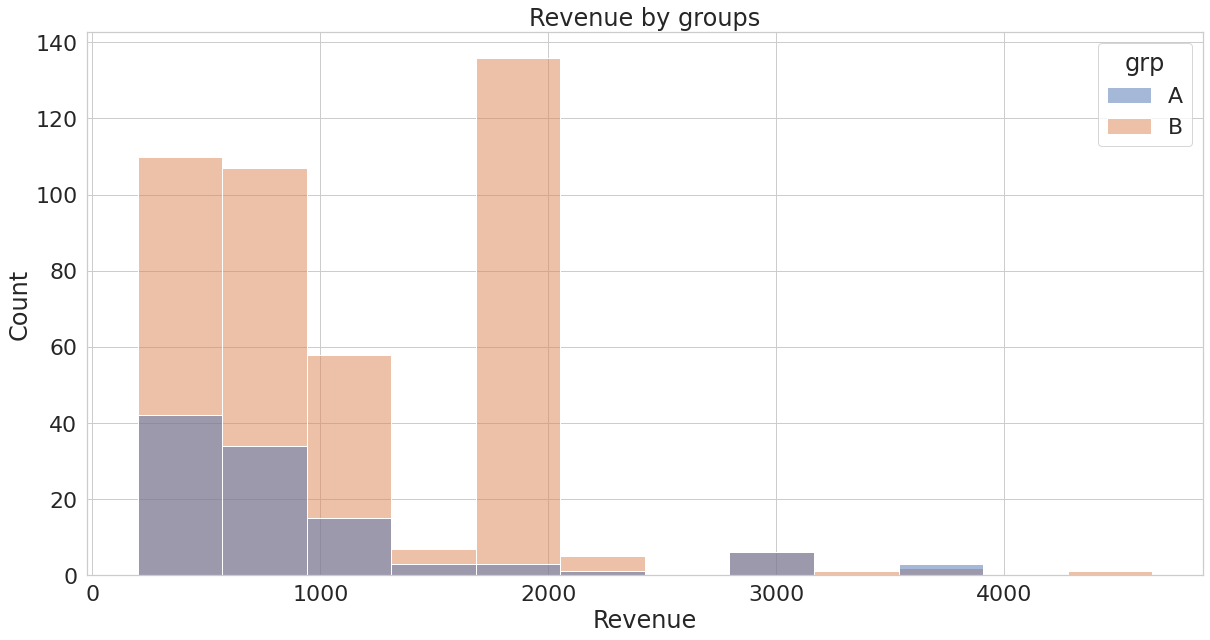

In [42]:
sns.set(font_scale=2, style='whitegrid', rc={'figure.figsize': (20, 10)})
sns.histplot(x=df_active_checks_new.rev, hue=df_active_checks_new.grp)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title("Revenue by groups")
plt.show()

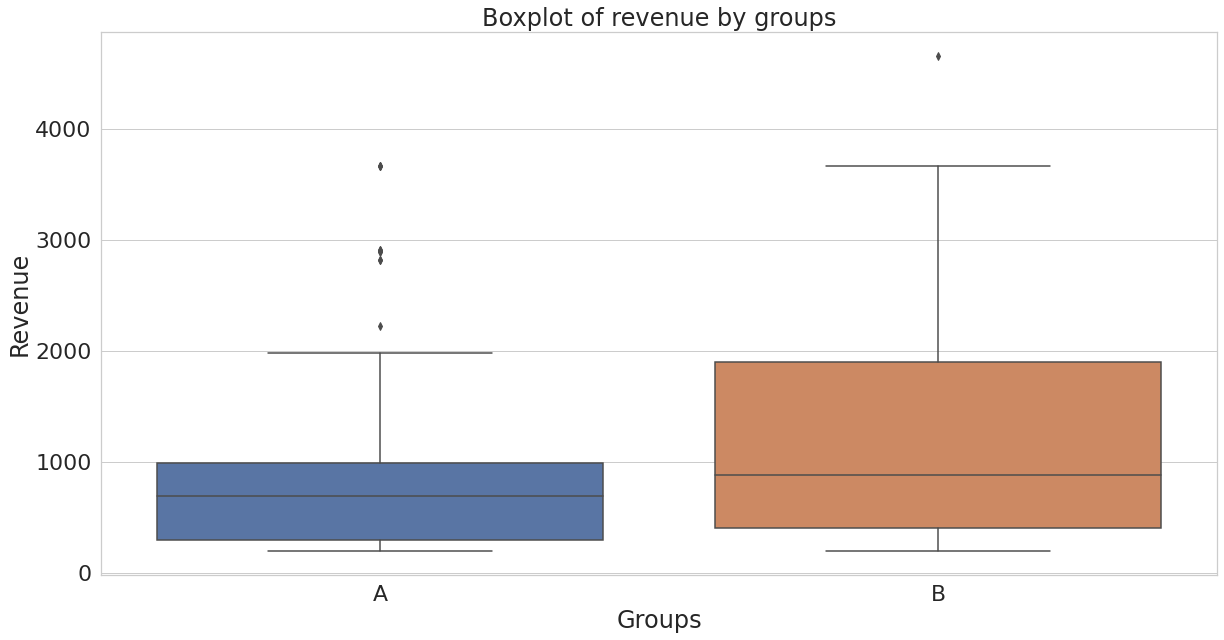

In [43]:
# и построим боксплот
sns.boxplot(data=df_active_checks_new, x='grp', y='rev')
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.title("Boxplot of revenue by groups")
plt.show()

Как видно из графиков, значения тестовой группы выше, чем у контрольной. Связано это с тем, что у нас не равное распределение пользователей по группам (в тестовой пользователей больше, приблизительно, в 4 раза). Из гистограммы видно, что все значения одинаково пропорциональны, кроме оплат тестовой группы, около 2000 (на боксплоте, так же видно, что отношение от 25 процентиля до медианы практически равны, а от медианы до 75 процентиля разница существенная).

In [44]:
# посмотрим на топ-10 распределения значений чеков в обоих группах
df_control.rev.value_counts().head(10), df_test.rev.value_counts().head(10)

(290.0     31
 690.0     19
 199.0      7
 580.0      6
 990.0      6
 1140.0     5
 590.0      5
 840.0      3
 3660.0     3
 1530.0     3
 Name: rev, dtype: int64,
 1900.0000    96
 290.0000     63
 690.0000     59
 199.0000     39
 1900.0001    36
 990.0000     35
 840.0000     24
 1140.0000    20
 580.0000      9
 398.0000      7
 Name: rev, dtype: int64)

Аномально большое число оплат в тестовой группе с чеком в 1900.

In [45]:
# посмотрим статпоказатели обеих групп
df_control.rev.describe(), df_test.rev.describe()

(count     107.000000
 mean      860.710280
 std       815.893445
 min       199.000000
 25%       290.000000
 50%       690.000000
 75%       990.000000
 max      3660.000000
 Name: rev, dtype: float64,
 count     433.000000
 mean     1106.997699
 std       741.714026
 min       199.000000
 25%       398.000000
 50%       880.000000
 75%      1900.000000
 max      4650.000000
 Name: rev, dtype: float64)

In [46]:
# оставим только нужные
stat_metrics = pd.DataFrame({'grp': ['A', 'B'],
                             'mean_revenue': [df_control.rev.mean(), df_test.rev.mean()],
                             'median_revenue': [df_control.rev.median(), df_test.rev.median()]})
stat_metrics

,grp,mean_revenue,median_revenue
0,A,860.710280,690.0
1,B,1106.997699,880.0


Видим, что значения средней и медианной оплат тестовой группы выше. Это обусловлено теми аномальными значениями тестовой группы на гистограмме. Провести глубокий анализ, является ли эта аномалия ошибкой или это обусловлено изменениями механики оплаты, не представляется возможным.
Так как АВ-тест уже проведен и различие в значениях существует, необходимо проверить статистическую значимость этих различий. Распределения оплат не является нормальным, а также нам интересно посмотреть на разницу медиан, не получится восользоваться t-тестом и непараметрическим критерием Манна-Уитни. Для данной цели воспользуемся bootstrap'ом.

## Гипотезы:
***

    Н0: Разница между оплатами в тестовой и контрольной группе отсутствует.
    Н1: Разница между оплатами в тестовой и контрольной группе статистически значима

In [47]:
# Функци расчета методом бутстрапа. Уровень статистической значимости примем 95 %, количество подвыборок 1000 шт.

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    statistic,  # интересующая нас статистика
    viz,  # визуализировать ли данные True/False
    boot_it=1000,  # количество бутстрэп-подвыборок
    bootstrap_conf_level=0.95,  # уровень значимости
):
        
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        # применяем выбранную статистику
        if statistic == np.mean:
            boot_data.append(statistic(samples_1 - samples_2))
        elif statistic == np.median:
            boot_data.append(statistic(samples_1) - statistic(samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, 0.5, right_quant])
        
    p_value = min((pd_boot_data < 0).sum()[0], (pd_boot_data > 0).sum()[0]) * 2 / len(pd_boot_data)
        
    # Визуализация
    if viz is True:
        plt.hist(pd_boot_data[0], bins=50)

        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

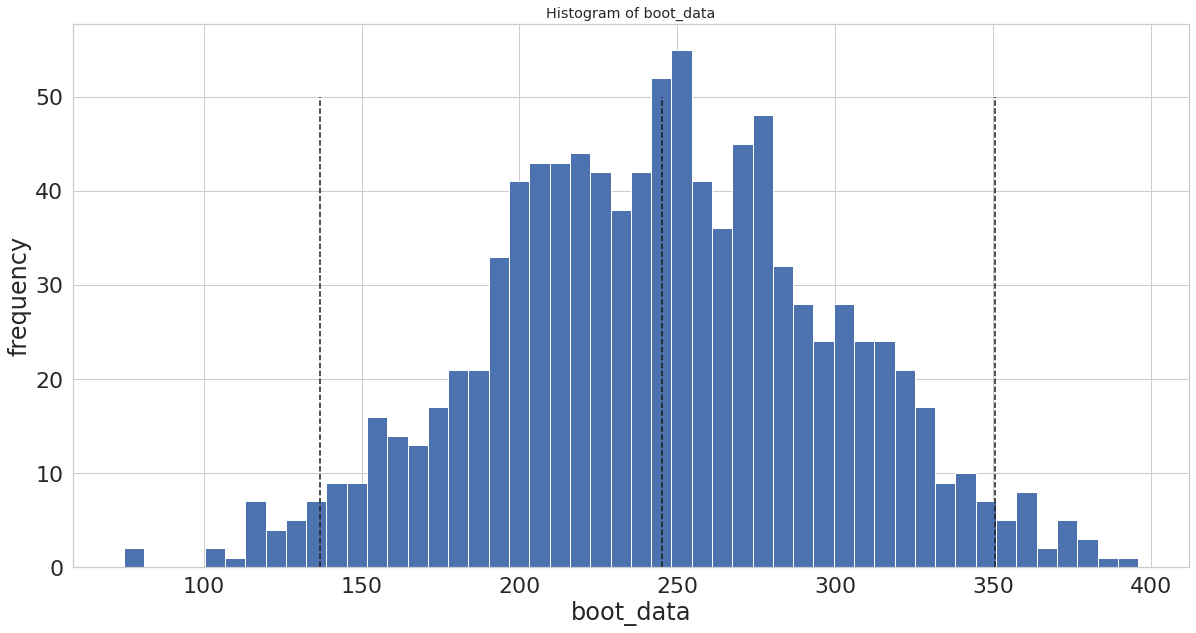

{'ci':                 0
 0.025  136.838172
 0.500  245.181301
 0.975  350.467041,
 'p_value': 0.0}

In [48]:
# расчет бутстрапом средних оплат
bootstrap_mean = get_bootstrap(df_test.dropna().rev, df_control.dropna().rev, np.mean, True)
bootstrap_mean

Полученный P-value меньше 0,05, значит мы можем отклонить нулевую гипотезу о равенстве средних чеков. Но, так как среднее очень чувствительно к выбросам, проведем проверку на медианный чек.

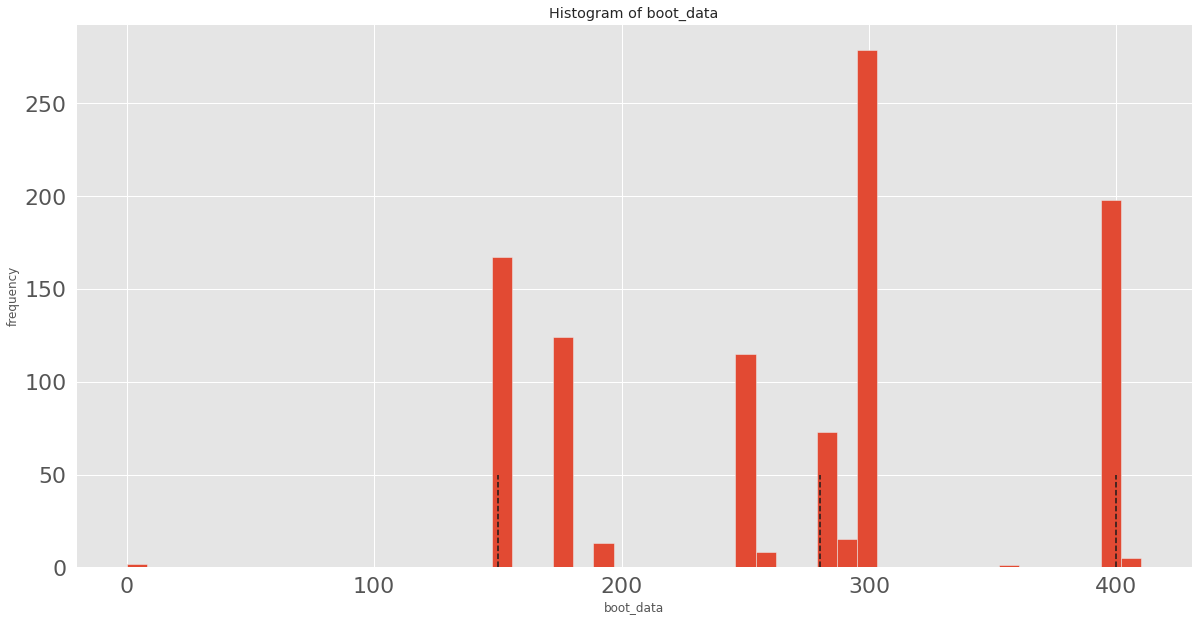

{'ci':            0
 0.025  150.0
 0.500  280.0
 0.975  400.0,
 'p_value': 0.0}

In [49]:
# расчет бутстрапом медианных оплат
bootstrap_median = get_bootstrap(df_test.dropna().rev, df_control.dropna().rev, np.median, True)
bootstrap_median

P-value < 0,05, а значит мы отклоняем нулевую гипотезу, медианные значения чеков тестовой группы выше, чем у контрольной.
***
Приведем результаты в виде таблицы метрик. Помимо конверсии из активных пользователей в покупку, укажем ARPAU и ARPPU.

In [50]:
# расчет метрик по группам
metrics = df_active_checks_new.assign(reve=df_active_checks_new.rev)
metrics = metrics.groupby('grp', as_index=False) \
                 .agg({'id': 'count', 'rev': 'count', 'reve': 'sum'}) \
                 .rename(columns={'id': 'active_users', 'rev': 'paying_users', 'reve': 'total_revenue'})
metrics = metrics.assign(CR=(metrics.paying_users / metrics.active_users).mul(100).round(2),
                         ARPAU=(metrics.total_revenue / metrics.active_users).round(2),
                         ARPPU=(metrics.total_revenue / metrics.paying_users).round(2),
                         median_rev=stat_metrics.median_revenue)
metrics = metrics[['grp', 'CR', 'ARPAU', 'ARPPU', 'median_rev']]
metrics

,grp,CR,ARPAU,ARPPU,median_rev
0,A,6.84,58.88,860.71,690.0
1,B,6.26,69.34,1107.00,880.0


In [51]:
# посмортим на изменение метрик в процентах
metrics_change = (metrics.drop(columns='grp').pct_change() * 100).round(2).dropna()
metrics_change

,CR,ARPAU,ARPPU,median_rev
1,-8.48,17.76,28.61,27.54


## Вывод
***
После проведения эксперимента можно сказать следующее:
- Конверсия в покупку активных пользователей уменьшилась на 8,48 %, это изменение статистически не значимо;
- Средний чек платящих пользователей увеличился на 28,61 %, это изменение статистически значимо;
- Медианный чек платящих пользователей увеличился на 27,54 %, это изменение статистически значимо.
***
По полученным результатам можно сделать вывод, что изначальная гипотеза опроверглась, но изменение механики оплаты услуг на сайте положительно повлияло на выручку. Однако на основании полученных данных эксперимента и проведенного анализа, я считаю, новую механику выводить на всех пользователей рано. В данном эксперименте были зафиксированны ошибки (не все платящие считались активными) и аномальные значения по оплатам в тестовой группе. Необходимо выяснить, ошибки ли это и если да, устранить их. После, провести повторный АВ-тест, если результаты повторятся, тогда выкатывать изменения на всех пользователей.

## Задание 2. SQL
***
### 2.1 Очень усердные ученики.
***
#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

#### 2.1.2 Задача

Дана таблица peas. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

### Решение

    WITH stud AS (
    SELECT
        *,
        LAG(timest, 19) OVER(PARTITION BY st_id ORDER BY timest) AS twenty_tasks,
        timest - LAG(timest, 19) OVER(PARTITION BY st_id ORDER BY timest) AS twenty_task_duration
    FROM
        peas
    WHERE 
        DATE_TRUNC('month', timest) = '2020-03-01 00:00:00'
        AND correct = True
    )

    SELECT
        COUNT(DISTINCT st_id)
    FROM
        stud
    WHERE
        twenty_task_duration <= '01:00:00'

### 2.2 Оптимизация воронки
***
#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача

Дана таблицы: peas (см. выше), studs и checks:

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

### Решение

    WITH
    -- Число студентов в эксперименте и число активных студентов по группам
        num_users AS (
            SELECT 
                s.test_grp,
                COUNT(DISTINCT s.st_id) AS num_user,
                COUNT(DISTINCT p.st_id) AS num_active_user
            FROM
                studs AS s
            LEFT JOIN
                peas AS p
            ON
                s.st_id = p.st_id
            GROUP BY
                s.test_grp
        ),

    -- Суммарный доход от студентов и количество платящих студентов по группам     
        checks_parametrs AS (
            SELECT
                s.test_grp,
                SUM(c.money) AS revenue,
                COUNT(DISTINCT c.st_id) AS num_paying_st
            FROM
                studs AS s
            JOIN
                checks AS c
            ON
                s.st_id = c.st_id
            GROUP BY
                s.test_grp
        ),

    -- Число активных студентов изучающих математику по группам    
        num_active_math AS (
            SELECT
                s.test_grp,
                COUNT(DISTINCT p.st_id) AS num_active_math_st
            FROM
                peas AS p
            JOIN
                studs AS s
            ON
                p.st_id = s.st_id
            WHERE
                p.subject = 'math'
            GROUP BY
                s.test_grp
        ),

    -- Число студентов оплачивающих математику по группам    
        num_math_checks AS (
            SELECT
                s.test_grp,
                COUNT(DISTINCT c.st_id) AS num_paying_math
            FROM
                checks AS c
            JOIN
                studs AS s
            ON
                c.st_id = s.st_id
            WHERE
                c.subject = 'math'
            GROUP BY
                s.test_grp
        )

    -- Запрос требуемых метрик
    SELECT
        nu.test_grp,
        ROUND((cp.revenue / nu.num_user) , 2) AS ARPU,
        ROUND((cp.revenue / nu.num_active_user) , 2) AS ARPAU,
        ROUND((cp.num_paying_st * 100 / nu.num_user) , 2) AS CR,
        ROUND((cp.num_paying_st * 100 / nu.num_active_user) , 2) AS CR_active,
        ROUND((nmc.num_paying_math * 100 / nam.num_active_math_st) , 2) AS CR_active_math
    FROM
        num_users AS nu
    JOIN
        checks_parametrs AS cp
    ON
        nu.test_grp = cp.test_grp
    JOIN
        num_active_math AS nam
    ON
        nu.test_grp = nam.test_grp
    JOIN
        num_math_checks AS nmc
    ON
        nu.test_grp = nmc.test_grp

## Задание 3. Python
***
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.
***
### 1. Функция подгружения дополнительных данных

In [52]:
# url загрузки файла положим в переменную
url_groups_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'

In [53]:
# Функция принимает новые данные и выводит пересчитанные метрики.

def new_data_metrics(
    url,  # url загрузки файла
    previous_metrics=metrics  # метрики предыдущего расчета
):
    # подготавливаем данные
    df_groups_add = pd.read_csv(url_base + url, 
                                names=['id', 'grp'], header=0)  # подгружаем новые данные
    df_group = pd.concat([df_groups, df_groups_add])  # объединение старых и новых данных
    active_groups = df_active_studs.merge(df_group, how='left', on='id')  # разделение активных пользователей по группам
    checks_groups = df_checks.merge(df_group, how='left', on='id')  # разделение платящих пользователей по группам
    active_checks = active_groups.merge(checks_groups, 
                                        how='outer', on=['id', 'grp'])  # объединяем с учетом неучтенных покупателей
    
    # расчитываем метрики
    metrics_new = active_checks.assign(reve=active_checks.rev)
    metrics_new = metrics_new.groupby('grp', as_index=False) \
                             .agg({'id': 'count', 'rev': 'count', 'reve': 'sum'}) \
                             .rename(columns={'id': 'active_users', 'rev': 'paying_users', 'reve': 'total_revenue'})
    metrics_new = metrics_new.assign(CR=(metrics_new.paying_users / metrics_new.active_users).mul(100).round(2), 
                                     ARPAU=(metrics_new.total_revenue / metrics_new.active_users).round(2), 
                                     ARPPU=(metrics_new.total_revenue / metrics_new.paying_users).round(2), 
                                     median_rev=[active_checks[active_checks.grp == 'A'].rev.median(), 
                                                 active_checks[active_checks.grp == 'B'].rev.median()])
    
    # метрики по группам
    metrics_new_short = metrics_new[['grp', 'CR', 'ARPAU', 'ARPPU', 'median_rev']]
    metrics_new_final = metrics.append(metrics_new_short) \
                               .reset_index().rename(columns={'index': 'experiment'})
    metrics_new_final.experiment = np.where(metrics_new_final.index <= 1, 'previous', 'current')
    
    # изменение метрик после эксперимента в процентах
    metrics_change_new = (metrics_new_short.drop(columns='grp').pct_change() * 100).round(2).dropna()
    
    # пересчет статзначимости экспериментов
    # Хи квадрат
    active_purchase = active_checks.assign(rev_status=np.where(active_checks.rev.isna(), 
                                                               'not_purchase', 
                                                               'purchase'))  # добавляем номинативный признак
    df_crosstab = pd.crosstab(active_purchase.grp, active_purchase.rev_status)  # таблица номинативных признаков 2х2
    g_new, p_new, dof_new, expctd_new = ss.chi2_contingency(df_crosstab)  # расчет Хи квадрат
    
    # Бутстрэп среднего чека
    mean_bootstrap = get_bootstrap(active_checks[active_checks.grp == 'B'].dropna().rev, 
                                   active_checks[active_checks.grp == 'A'].dropna().rev, 
                                   np.mean, 
                                   False)
    # Бутстрэп медианного чека
    median_bootstrap = get_bootstrap(active_checks[active_checks.grp == 'B'].dropna().rev, 
                                     active_checks[active_checks.grp == 'A'].dropna().rev, 
                                     np.median, 
                                     False)
    # финальная таблица метрик
    metrics_change_final = metrics_change_new.assign(CR_p_value=p_new, 
                                                     ARPPU_p_value=mean_bootstrap['p_value'], 
                                                     median_p_value=median_bootstrap['p_value'])
    metrics_change_final = metrics_change.append(metrics_change_final) \
                                         .reset_index().rename(columns={'index': 'experiment'})
    metrics_change_final.experiment = np.where(metrics_change_final.index <= 0, 'previous', 'current')
    
    return {'metrics_by_group': metrics_new_final, 
            'ratio_and_p_value': metrics_change_final}

In [54]:
result = new_data_metrics(url_groups_add)

In [55]:
result['metrics_by_group']

,experiment,grp,CR,ARPAU,ARPPU,median_rev
0,previous,A,6.84,58.88,860.71,690.0
1,previous,B,6.26,69.34,1107.00,880.0
2,current,A,6.83,58.77,860.71,690.0
3,current,B,6.27,69.51,1108.82,935.0


In [56]:
result['ratio_and_p_value']

,experiment,CR,ARPAU,ARPPU,median_rev,CR_p_value,ARPPU_p_value,median_p_value
0,previous,-8.48,17.76,28.61,27.54,NaN,NaN,NaN
1,current,-8.20,18.27,28.83,35.51,0.446443,0.0,0.0


### 2. Функция визуализации метрик

In [57]:
# Функция принимает новые метрики и строит их визуализаци.

def get_viz(metrics):
    data_viz = metrics['metrics_by_group'].query('experiment == "current"')
    
    plt.figure(figsize=(20, 15))
    # график конверсии активного пользователя в покупку
    plt.subplot(2, 2, 1)
    ax = sns.barplot(x='grp', y='CR', data=data_viz)
    ax.axes.set_title('Конверсия активного пользователя в покупку', fontsize=16)
    ax.set_xlabel('Group', fontsize=14)
    ax.set_ylabel('CR, %', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # график ARPAU
    plt.subplot(2, 2, 2)
    ax = sns.barplot(x='grp', y='ARPAU', data=data_viz)
    ax.axes.set_title('ARPAU', fontsize=16)
    ax.set_xlabel('Group', fontsize=14)
    ax.set_ylabel('Revenue', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # график ARPPU
    plt.subplot(2, 2, 3)
    ax = sns.barplot(x='grp', y='ARPPU', data=data_viz)
    ax.axes.set_title('ARPPU', fontsize=16)
    ax.set_xlabel('Group', fontsize=14)
    ax.set_ylabel('Revenue', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)    
    
    # график медианного чека
    plt.subplot(2, 2, 4)
    ax = sns.barplot(x='grp', y='median_rev', data=data_viz)
    ax.axes.set_title('Медианный чек', fontsize=16)
    ax.set_xlabel('Group', fontsize=14)
    ax.set_ylabel('Revenue', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)    

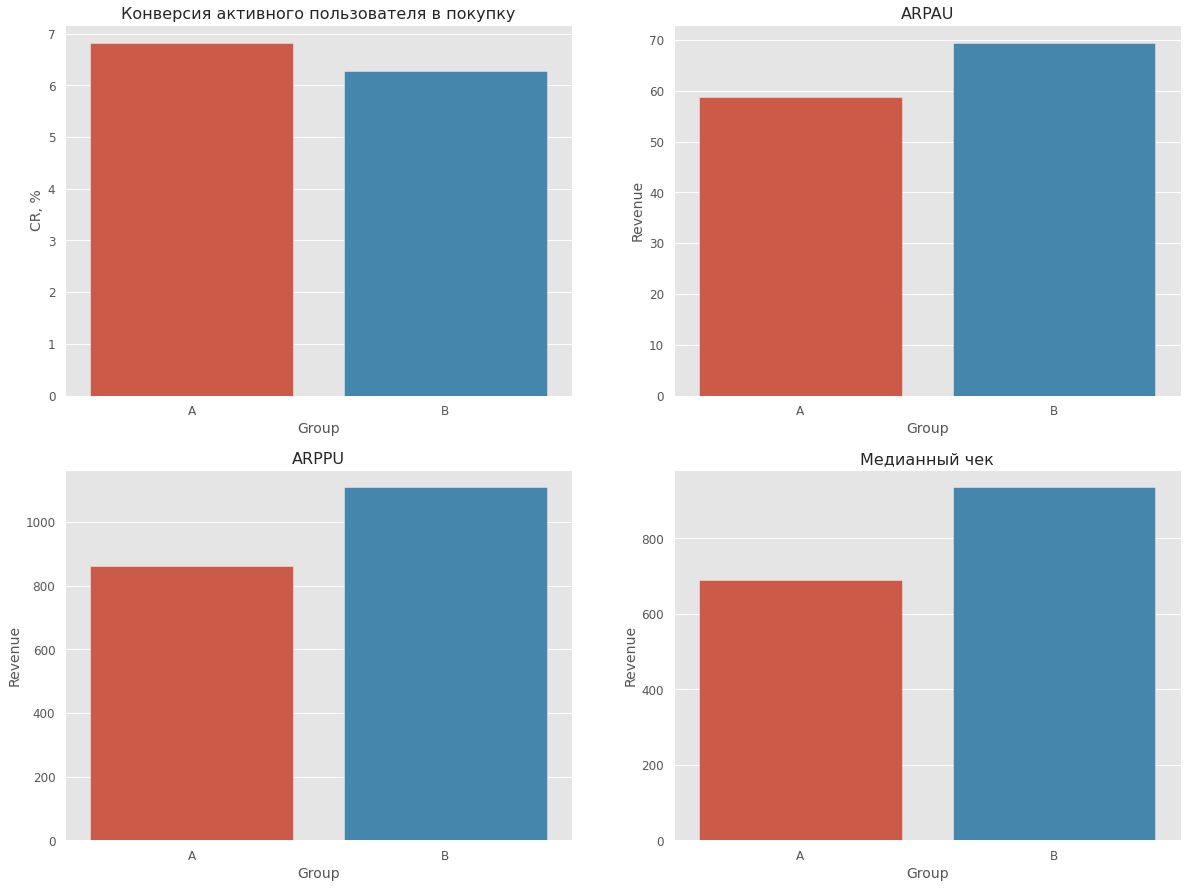

In [58]:
get_viz(new_data_metrics(url_groups_add))